# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle

from sklearn.metrics import pairwise_distances


class MyKmeans:
    def __init__(self, k=2, metric='euclidean', max_iter=100,
                 random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.EPS = 1e-9

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        if self.init == 'random':
            indexes = np.arange(X.shape[0])
            np.random.shuffle(indexes)
            self.centroids = X[indexes[:self.k]]
        elif self.init == 'k-means':
            self.centroids = [X[np.random.choice(np.arange(X.shape[0]))]]
            for i in range(1, self.k):
                probs = np.min(pairwise_distances(X, self.centroids), axis=-1)
                probs /= np.sum(probs)
                prob = np.random.random()
                index = 0
                indexes = set()
                while True:
                    prob -= probs[index]
                    if prob < 0:
                        break
                    index += 1
                    while index in indexes:
                        index += 1
                self.centroids.append(X[index])
                indexes.add(index)

        self.labels = self.predict(X)

        self.iterate(X)

        self.centroids = np.array(self.centroids)

        return self

    def iterate(self, X):
        for i in range(self.max_iter):
            clusters = [X[self.labels == i] for i in range(self.k)]
            new_cent = [np.mean(clusters[i], axis=0)
                        if clusters[i].shape[0] != 0 else self.centroids[i]
                        for i in range(self.k)]
            diffs = [new_cent[i] - self.centroids[i] for i in range(self.k)]
            if np.sqrt(np.sum(np.square(diffs))) < self.EPS:
                break
            self.centroids = new_cent
            self.labels = self.predict(X)

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """

        X_dist = pairwise_distances(X, self.centroids, metric='euclidean')
        labels = np.argmin(X_dist, axis=-1)
        return labels


class MiniBatchMyKmeans(MyKmeans):
    def gen_batch(self, X):
        batch_size = X.shape[0] // 10
        order = np.arange(X.shape[0])
        np.random.shuffle(order)
        X_batch = X[order][:batch_size, :]
        labels_batch = self.labels[order][:batch_size]
        return X_batch, labels_batch

    def iterate(self, X):
        for i in range(self.max_iter):
            X_batch, labels_batch = self.gen_batch(X)
            clusters = [X_batch[labels_batch == i] for i in range(self.k)]
            # непонятно, что делать, если один кластер остался без объектов,
            # так что наверное лучше ничего не делать
            new_cent = [np.mean(clusters[i], axis=0)
                        if clusters[i].shape[0] != 0 else self.centroids[i]
                        for i in range(self.k)]
            diffs = [new_cent[i] - self.centroids[i] for i in range(self.k)]
            if np.sqrt(np.sum(np.square(diffs))) < self.EPS:
                break
            self.centroids = new_cent
            self.labels = self.predict(X)

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

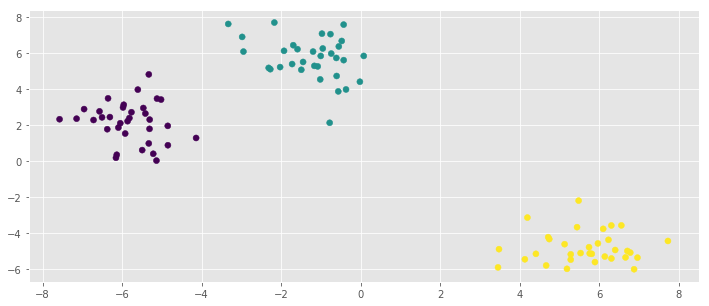

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

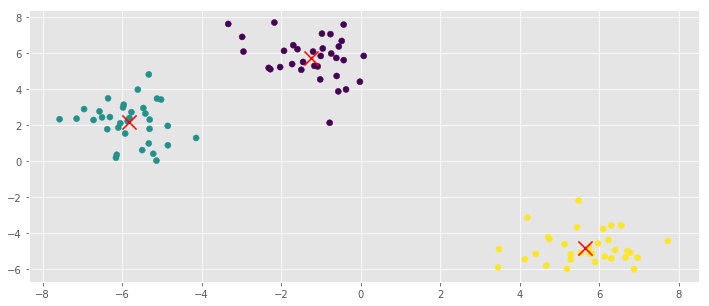

In [6]:
## Работоспособность MyKmeans
clf = MyKmeans(k=3, random_state=1234)
clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=clf.labels)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1], s=200, c='r', marker='x')

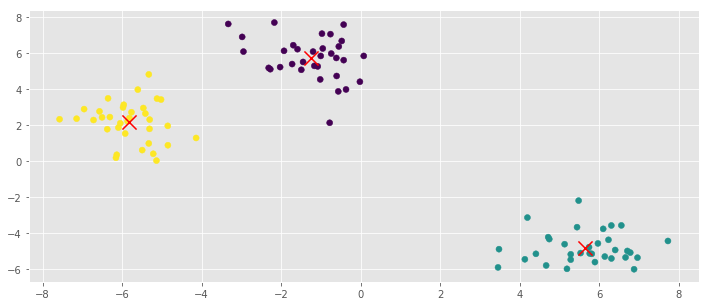

In [7]:
## Работоспособность MyKmeans++
clf = MyKmeans(k=3, init='k-means', random_state=1234)
clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=clf.labels)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1], s=200, c='r', marker='x')

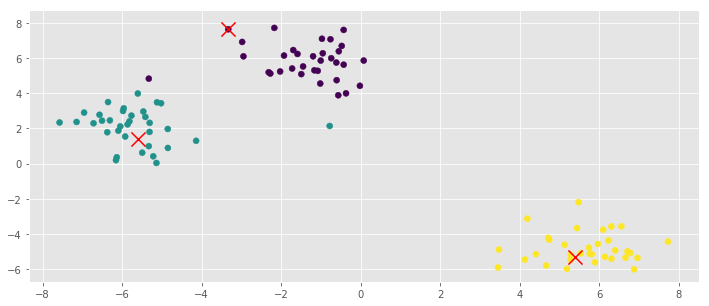

In [8]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
clf = MiniBatchMyKmeans(k=3, random_state=1234)
clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=clf.labels)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1], s=200, c='r', marker='x')

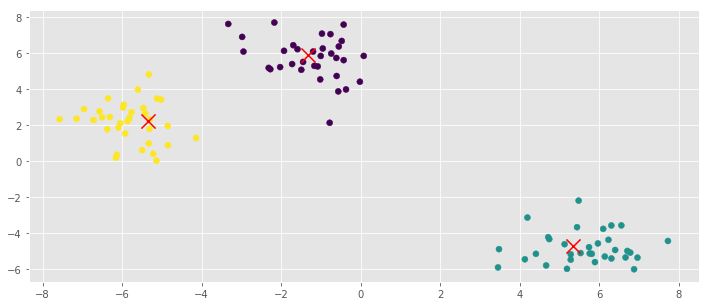

In [9]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchMyKmeans(k=3, init='k-means', random_state=1234)
clf.fit(X)
plt.scatter(X[:,0], X[:, 1], c=clf.labels)
plt.scatter(clf.centroids[:, 0], clf.centroids[:, 1], s=200, c='r', marker='x')

In [10]:
from time import time

# Проверка времени выполнения  
def plot_time(clf):
    sample_sizes = [100, 215, 464, 1000, 2154, 4642, 10000, 21544, 46416, 100000]
    times = []
    for size in sample_sizes:
        X, y = make_blobs(n_samples=size, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
        start = time()
        clf.fit(X)
        times.append(time() - start)

    plt.plot(times)
    plt.xticks(np.arange(len(sample_sizes)), sample_sizes)
    plt.show()
    print(list(map(lambda x: round(x, 3), times)))

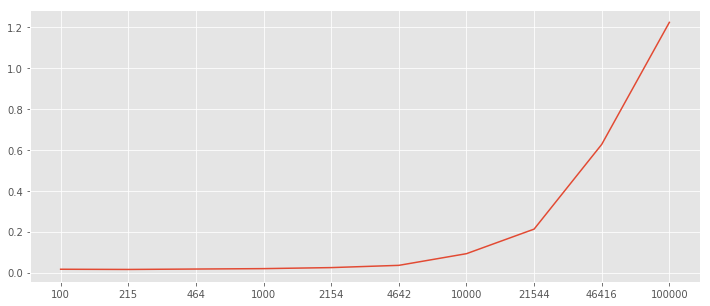

[0.017, 0.016, 0.018, 0.02, 0.025, 0.036, 0.093, 0.213, 0.627, 1.223]


In [11]:
## Время выполнения алгоритма Kmeans из sklearn
from sklearn.cluster import KMeans
clf = KMeans(n_clusters=3, random_state=123)
plot_time(clf)

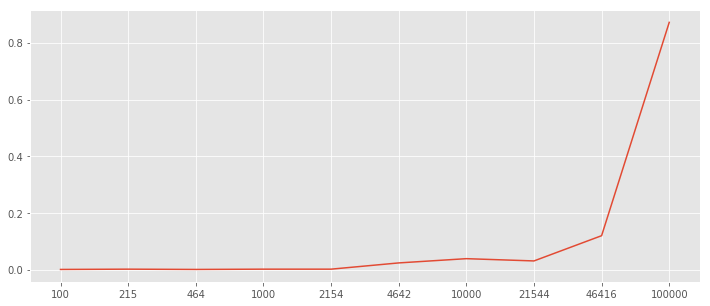

[0.001, 0.002, 0.001, 0.002, 0.002, 0.024, 0.039, 0.031, 0.12, 0.872]


In [12]:
## Время выполнения алгоритма MyKmeans
clf = MyKmeans(k=3, random_state=123)
plot_time(clf)

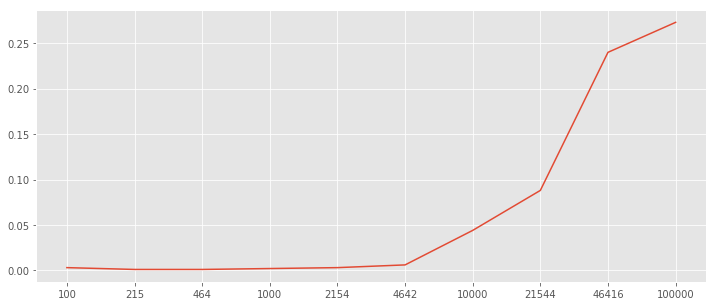

[0.003, 0.001, 0.001, 0.002, 0.003, 0.006, 0.044, 0.088, 0.24, 0.273]


In [13]:
## Время выполнения алгоритма MyKmeans++
clf = MyKmeans(k=3, init='k-means', random_state=123)
plot_time(clf)

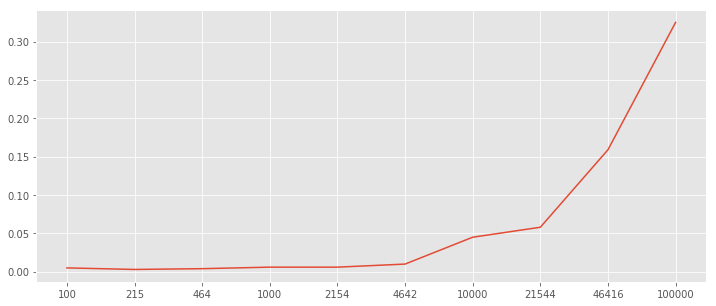

[0.005, 0.003, 0.004, 0.006, 0.006, 0.01, 0.045, 0.058, 0.159, 0.325]


In [14]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
clf = MiniBatchMyKmeans(k=3, random_state=123, max_iter=10)
plot_time(clf)

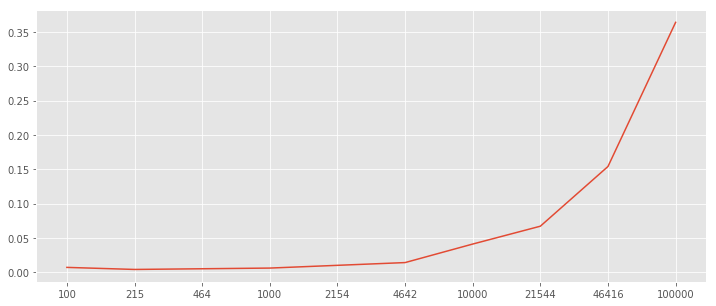

[0.007, 0.004, 0.005, 0.006, 0.01, 0.014, 0.041, 0.067, 0.154, 0.364]


In [15]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
clf = MiniBatchMyKmeans(k=3, init='k-means', random_state=123, max_iter=10)
plot_time(clf)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [16]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [17]:
data = df_sns[df_sns.columns[4:]]
data.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(data)

In [19]:
def get_result(clf):
    clf.fit(X)
    clusters = [X[clf.labels == i] for i in range(clf.k)]
    clusters_sizes = [clusters[i].shape[0] for i in range(clf.k)]
    clusters_order = np.argsort(clusters_sizes)[::-1]
    centroids = scaler.inverse_transform(clf.centroids)
    words = data.columns
    for i in clusters_order:
        order = np.argsort(centroids[i])[::-1]
        print("cluster: {}; size: {}".format(i, clusters_sizes[i]))
        for j in order[:7]:
            print("{}: {}; ".format(words[j], round(centroids[i,j], 3),), end='')
        print('\n')

In [20]:
## MyKMeans
clf = MyKmeans(k=9, random_state=123)
get_result(clf)

cluster: 8; size: 19640
music: 0.545; god: 0.315; dance: 0.217; hair: 0.184; shopping: 0.171; band: 0.163; rock: 0.154; 

cluster: 7; size: 4431
dance: 1.22; music: 1.11; shopping: 0.996; cute: 0.976; hair: 0.796; mall: 0.736; god: 0.613; 

cluster: 4; size: 2053
football: 1.478; soccer: 1.393; basketball: 1.2; baseball: 0.867; music: 0.793; sports: 0.654; god: 0.448; 

cluster: 0; size: 921
hair: 3.263; sex: 2.629; music: 2.2; kissed: 1.745; die: 1.296; rock: 1.119; drugs: 1.061; 

cluster: 5; size: 902
softball: 2.793; volleyball: 2.074; basketball: 0.752; music: 0.71; shopping: 0.514; god: 0.506; hair: 0.451; 

cluster: 3; size: 841
hollister: 1.509; abercrombie: 1.171; shopping: 0.927; music: 0.923; hair: 0.919; dance: 0.697; mall: 0.677; 

cluster: 6; size: 581
band: 4.883; marching: 1.558; music: 1.382; god: 0.547; dance: 0.475; hair: 0.38; rock: 0.37; 

cluster: 2; size: 391
god: 5.0; jesus: 2.217; church: 1.862; bible: 1.115; music: 1.1; band: 0.432; hair: 0.43; 

cluster: 1; s

In [25]:
## MyKMeans++
clf = MyKmeans(k=9, init='k-means', random_state=123)
get_result(clf)

cluster: 3; size: 19563
music: 0.54; god: 0.29; dance: 0.224; hair: 0.189; shopping: 0.175; band: 0.162; cute: 0.158; 

cluster: 7; size: 4477
dance: 1.152; music: 1.108; god: 1.069; shopping: 0.975; cute: 0.915; church: 0.757; hair: 0.702; 

cluster: 2; size: 2477
football: 1.319; basketball: 1.299; soccer: 1.121; music: 0.781; baseball: 0.741; volleyball: 0.641; sports: 0.605; 

cluster: 0; size: 1075
hair: 2.885; music: 1.951; sex: 1.903; kissed: 1.443; die: 1.187; rock: 0.978; drugs: 0.965; 

cluster: 5; size: 852
hollister: 1.502; abercrombie: 1.156; shopping: 0.915; music: 0.904; hair: 0.897; dance: 0.689; mall: 0.684; 

cluster: 6; size: 585
band: 4.867; marching: 1.562; music: 1.379; god: 0.564; dance: 0.474; hair: 0.376; rock: 0.368; 

cluster: 1; size: 507
softball: 4.679; music: 0.85; basketball: 0.763; god: 0.6; shopping: 0.525; volleyball: 0.523; hair: 0.497; 

cluster: 8; size: 430
tennis: 3.456; music: 0.833; god: 0.512; shopping: 0.421; dance: 0.4; hair: 0.391; church: 

In [22]:
## MyKMeans с MiniBatchMyKMeans
clf = MiniBatchMyKmeans(k=9, random_state=123)
get_result(clf)

cluster: 8; size: 20151
music: 0.544; god: 0.323; dance: 0.216; band: 0.179; hair: 0.172; shopping: 0.153; rock: 0.149; 

cluster: 7; size: 4870
dance: 1.129; music: 1.114; shopping: 0.944; hair: 0.935; cute: 0.841; mall: 0.679; god: 0.672; 

cluster: 5; size: 1756
softball: 1.481; basketball: 1.332; baseball: 1.168; football: 1.01; music: 0.837; sports: 0.745; volleyball: 0.644; 

cluster: 4; size: 829
hollister: 1.532; abercrombie: 1.26; music: 1.065; hair: 0.87; shopping: 0.857; dance: 0.701; cute: 0.675; 

cluster: 0; size: 666
hair: 4.302; sex: 2.887; music: 2.509; kissed: 2.132; die: 1.509; drugs: 1.17; god: 1.132; 

cluster: 3; size: 581
hot: 2.66; music: 1.08; cute: 0.96; dance: 0.8; hair: 0.64; god: 0.58; shopping: 0.52; 

cluster: 6; size: 510
band: 5.414; marching: 1.603; music: 1.534; football: 0.552; dance: 0.5; hair: 0.483; shopping: 0.379; 

cluster: 2; size: 392
god: 4.769; jesus: 2.981; church: 2.038; music: 1.115; bible: 0.865; dance: 0.538; die: 0.462; 

cluster: 1; 

In [23]:
## MyKMeans++ с MiniBatchMyKMeans
clf = MiniBatchMyKmeans(k=9, init='k-means', random_state=123)
get_result(clf)

cluster: 3; size: 19973
music: 0.514; god: 0.316; dance: 0.213; shopping: 0.197; hair: 0.181; band: 0.166; church: 0.148; 

cluster: 7; size: 4160
music: 1.127; dance: 1.113; cute: 1.069; hair: 1.045; shopping: 0.997; mall: 0.823; church: 0.599; 

cluster: 2; size: 2418
basketball: 1.335; football: 1.21; soccer: 1.022; music: 0.786; baseball: 0.754; sports: 0.687; volleyball: 0.665; 

cluster: 5; size: 821
hollister: 1.728; abercrombie: 1.37; hair: 1.025; shopping: 0.975; music: 0.938; dance: 0.691; mall: 0.667; 

cluster: 8; size: 636
cheerleading: 3.048; music: 0.935; hair: 0.855; dance: 0.774; shopping: 0.661; basketball: 0.548; god: 0.532; 

cluster: 0; size: 598
hair: 4.0; sex: 3.6; music: 2.52; kissed: 2.38; die: 1.58; dance: 1.22; drugs: 1.18; 

cluster: 1; size: 494
softball: 4.75; music: 0.85; volleyball: 0.683; shopping: 0.617; cute: 0.483; hair: 0.433; basketball: 0.433; 

cluster: 4; size: 455
god: 3.609; jesus: 2.717; church: 2.217; music: 1.13; bible: 0.848; shopping: 0.6

## Вывод

Всеми вариациями алгоритма выделяются приблизительно одинаковые основные кластеры:

Имеется один самый большой кластер (примерно 20000 элементов), в котором судя по всему много нулей, <br>
вероятно это унылое большинство.
Ещё два крупных кластера - примерно на 4500 и 2000 элементов - больше всего интересуются музыкой и спортом соответственно.

Остальные кластеры, где меньше 1000 элементов, расположены в относительно случайном порядке, и в каждом есть <br>
несколько сильно выраженных слов:
* "hollister", "abercrombie" (видимо бренды одежды)
* "cheerleading"
* "god", "jesus", "church"
* "hair", "sex", "music", "kissed"
* "band"
* "softball"/"hot"

Похоже на "выбросы" в пространстве точек, достаточно далёкие от основной плотной массы около нуля.

Алгоритмы работают приблизительно одинаково: <br>
<b><i>kmeans++</i></b> улучшает только начальное приближение, и если кластеры не слишком отделены друг от друга, центроиды как-то расползутся в приблизительно одни и те же точки; если кластеры расположены далеко друг от друга, начальное приближение может кинуть два центроида в один кластер, и тогда один кластер разобьётся на части, а какие-то ещё склеятся, как было в игрушечном примере, поэтому модификация полезная, но сути алгоритма не меняет.<br>
<b><i>minibatch</i></b> ухудшает сходимость, и поэтому в основном алгоритм завершается по максимальному числу итераций, так что выигрыша по скорости по сути нет, имеет смысл только для экономии памяти; при достаточно равномерных батчах центроиды ведут себя почти как для обычного kmeans, просто сильнее колеблются относительно равновесия.
